<a href="https://colab.research.google.com/github/WaleedAhmed565/Ai-lab1/blob/main/cardiovascular_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U scikit-learn joblib pandas --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 80.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler
import joblib


In [5]:
class WTModel:
    def __init__(self):
        self.is_classification = None
        self.models = []
        self.meta_model = None
        self.scaler = StandardScaler()

    def fit(self, X, y):
        # Scale
        X = self.scaler.fit_transform(X)

        # Decide classification or regression
        self.is_classification = (len(np.unique(y)) < 20 and y.dtype in [np.int32, np.int64])

        if self.is_classification:
            self.models = [
                LogisticRegression(max_iter=500),
                RandomForestClassifier(n_estimators=200, random_state=42),
                GradientBoostingClassifier(n_estimators=200, random_state=42)
            ]
            self.meta_model = LogisticRegression(max_iter=500)
        else:
            self.models = [
                LinearRegression(),
                RandomForestRegressor(n_estimators=200, random_state=42),
                GradientBoostingRegressor(n_estimators=200, random_state=42)
            ]
            self.meta_model = LinearRegression()

        # Train base models
        base_preds = []
        for model in self.models:
            model.fit(X, y)
            base_preds.append(model.predict(X))
        base_preds = np.array(base_preds).T

        # Train meta learner
        self.meta_model.fit(base_preds, y)

    def predict(self, X):
        X = self.scaler.transform(X)
        base_preds = []
        for model in self.models:
            base_preds.append(model.predict(X))
        base_preds = np.array(base_preds).T
        return self.meta_model.predict(base_preds)


In [7]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

# Ye first uploaded file ka naam lega
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename, sep=";")
print(df.shape)


Saving cardio.csv to cardio (1).csv
(70000, 13)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (56000, 11) Test: (14000, 11)


In [9]:
model = WTModel()
model.fit(X_train, y_train)
print("✅ WT Model trained successfully on cardio dataset")


✅ WT Model trained successfully on cardio dataset


In [10]:
preds = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds))


Accuracy: 0.7130714285714286

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.72      0.72      7004
           1       0.72      0.70      0.71      6996

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000
weighted avg       0.71      0.71      0.71     14000



In [14]:
print(X.columns)


Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active'],
      dtype='object')


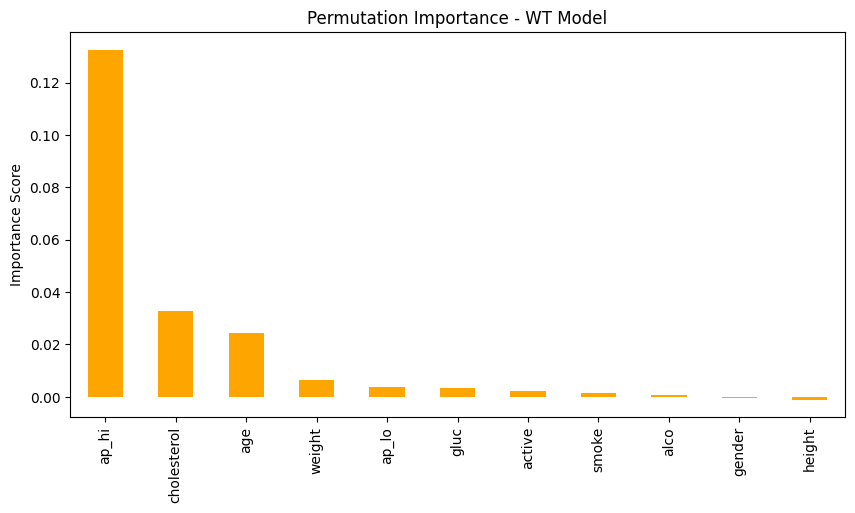

In [16]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring="accuracy"   # ✅ added scoring
)

perm_importance = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
perm_importance.plot(kind='bar', color="orange")
plt.title("Permutation Importance - WT Model")
plt.ylabel("Importance Score")
plt.show()


In [18]:
print("Model expects features in this order:\n")
print(list(X.columns))


Model expects features in this order:

['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']


In [21]:
custom_data = {
    "age": [55],
    "gender": [1],
    "height": [170],
    "weight": [80],
    "ap_hi": [140],
    "ap_lo": [90],
    "cholesterol": [2],
    "gluc": [1],
    "smoke": [0],
    "alco": [0],
    "active": [1]
}

custom_df = pd.DataFrame(custom_data)

# Prediction
prediction = model.predict(custom_df)[0]
print("Custom Input Prediction:", " patient predicted with cardiovascular Disease" if prediction==1 else "No Disease")


Custom Input Prediction:  patient predicted with cardiovascular Disease


In [23]:
custom_data = {
    "age": [35],        # young age
    "gender": [1],      # male (example)
    "height": [175],
    "weight": [70],
    "ap_hi": [120],     # normal systolic BP
    "ap_lo": [80],      # normal diastolic BP
    "cholesterol": [1], # normal
    "gluc": [1],        # normal
    "smoke": [0],
    "alco": [0],
    "active": [1]       # physically active
}

custom_df = pd.DataFrame(custom_data)
custom_df = custom_df[X.columns]   # reorder to match training data

prediction = model.predict(custom_df)[0]
print("Custom Input Prediction:", "patient predicted with cardiovascula Disease" if prediction==1 else "No Disease")


Custom Input Prediction: No Disease


In [24]:
import joblib

# Save trained model
joblib.dump(model, "WT_model.pkl")

print("✅ WT Model saved as WT_model.pkl")


✅ WT Model saved as WT_model.pkl


In [25]:
import joblib

# Load trained WT model
model = joblib.load("WT_model.pkl")

# Use it for prediction
prediction = model.predict(custom_df)
